In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ks_2samp
# from scipy.stats import norm

In [2]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## Nôi dung 
### <a href='#1'> 1. Xử lý dữ liệu
#### <a href='#1.1'> 1.1. Đưa dữ liệu json về dạng bảng
#### <a href='#1.2'> 1.2. Feature Engineering (biến đổi các thuộc tính, thêm các thuộc tính mới)
#### <a href='#1.3'> 1.3. Kiểm tra phân phối của dữ liệu
#### <a href='#1.4'> 1.4. Kiểm tra tính cân bằng dữ liệu
#### <a href='#1.5'> 1.5. Outlier
### <a href='#2'> 2. Phân tích mô tả
#### <a href='#2.1'> 2.1. Đánh giá khả năng tác động từng thuộc tính nên kết quả mục tiêu 
#### <a href='#2.2'> 2.2. Đánh giá tương quan
### <a href='#3'> 3. Mô hình Random Forest
#### <a href='#3.1'> 3.1. Lựa chọn thuộc tính
#### <a href='#3.2'> 3.2. Xây dựng, tinh chỉnh và đánh giá mô hình
### <a href='#4'> 4. Mô hình XGBoost
#### <a href='#4.1'> 4.1. Xây dựng mô hình
#### <a href='#4.2'> 4.2. Tuning hyper-parameter

### <a id= '1'> 1. Xử lý dữ liệu

#### <a id= '1.1'> 1.1. Đưa dữ liệu json về dạng bảng

In [4]:
df=pd.read_csv(r'1MG.csv')

In [5]:
# 1.1.Đưa dữ liệu json về dạng bảng
df=df.reset_index()
import ast
df.transaction_info.apply(ast.literal_eval)
df2=pd.DataFrame(df.transaction_info.apply(ast.literal_eval).sum(),index=df.index.repeat(df.transaction_info.apply(ast.literal_eval).str.len())).reset_index()

,index,csn,date,transaction_info
0,0,Y2NgaWJoYw==,2018-03-02,"[{'article': '10020163', 'salesquantity': 2.0,..."
1,1,Y2NgaWJoYw==,2018-03-04,"[{'article': '10026562', 'salesquantity': 3.0,..."
2,2,Y2NgaWlpYA==,2018-02-27,"[{'article': '10013531', 'salesquantity': 1.0,..."
3,3,Y2NgaWlpYA==,2018-03-16,"[{'article': '10008991', 'salesquantity': 1.0,..."
4,4,Y2NgaWlpYA==,2018-05-24,"[{'article': '10009698', 'salesquantity': 1.0,..."
...,...,...,...,...
95,95,Y2Nha2ZmYw==,2018-03-18,"[{'article': '10083185', 'salesquantity': 1.0,..."
96,96,Y2Nha2hmZg==,2018-03-06,"[{'article': '10016393', 'salesquantity': 1.0,..."
97,97,Y2Nha2hmZg==,2018-04-12,"[{'article': '10013198', 'salesquantity': 1.0,..."
98,98,Y2Nha2hmZg==,2018-04-14,"[{'article': '10054854', 'salesquantity': 0.62..."


In [6]:
df=pd.merge(df[['csn','date', 'index']],df2,on='index',how='left')

#### <a id= '1.2'> 1.2. Feature Engineering (biến đổi các thuộc tính, thêm các thuộc tính mới)

In [7]:
#add column month
df['date']=pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['total_price']=df['price']*df['salesquantity']

In [8]:
#tìm các sản phầm có tần suất mua cao đối với từng khách hàng
df_item_1=df.groupby(['csn','article'])['salesquantity'].count().reset_index()
df_item_2=df_item_1.groupby('article')['salesquantity'].mean().reset_index()
df_item_3=df_item_2.sort_values(by='salesquantity',ascending=False )
df_top=df_item_3[df_item_3['salesquantity']>1]

In [10]:
df=pd.merge(df,df_top, on= 'article', how='left')
df.loc[df['salesquantity_y'].notnull()==True, 'top_item']=1
df.loc[df['salesquantity_y'].notnull()==False, 'top_item']=0

Dataset gồm các dữ liệu mua hàng từ tháng 2 đến tháng 6

Tính toán các thuộc tính phái sinh (theo tháng): 
- unique_item: số lượng loại item KH mua
- quantity: số lượng mua
- freq: tần suất (số lần) mua
- price: tổng tiền mua 
- top_item: tổng số lần mua các sản phẩm top (sản phẩm có tần suất mua cao)

In [11]:
df2=df.groupby(['csn','month']).agg({'article': 'nunique','salesquantity_x': ['sum','count'], 'total_price': 'sum', 'top_item':'sum'}).reset_index()
df2.columns=['csn','month','unique_item','quantity','freq','total_price','top_item']

In [12]:
#thêm các tháng còn thiếu cho từng KH, đảm bảo có dữ liệu từng khách từ t2 đến t6. Các tháng thêm vào giá trị bằng 0
df_month=df2.set_index(['month', 'csn'])[['unique_item']].unstack().unstack().reset_index()
df2=pd.merge(df_month[['csn','month']], df2, on=['csn','month'], how='left').fillna(0)

In [13]:
#gắn nhãn dữ liệu
df2.loc[df2['total_price'] >0, 'purchase']=1
df2.loc[df2['total_price'] == 0, 'purchase']=0

In [14]:
df2

,csn,month,unique_item,quantity,freq,total_price,top_item,purchase
0,Y2NgaWJoYw==,2,0.0,0.0,0.0,0.0,0.0,0.0
1,Y2NgaWJoYw==,3,3.0,7.0,3.0,161500.0,3.0,1.0
2,Y2NgaWJoYw==,4,0.0,0.0,0.0,0.0,0.0,0.0
3,Y2NgaWJoYw==,5,0.0,0.0,0.0,0.0,0.0,0.0
4,Y2NgaWJoYw==,6,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
99995,amxpbWNk,2,0.0,0.0,0.0,0.0,0.0,0.0
99996,amxpbWNk,3,0.0,0.0,0.0,0.0,0.0,0.0
99997,amxpbWNk,4,4.0,5.0,4.0,305400.0,1.0,1.0
99998,amxpbWNk,5,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#thuộc tính tương ứng 4 thuộc tính phái sinh (phía trên) tại thời điểm 1 tháng trước 
df2['unique_item_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['unique_item'].shift(1)).fillna(0)
df2['quantity_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['quantity'].shift(1)).fillna(0)
df2['freq_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['freq'].shift(1)).fillna(0)
df2['price_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['total_price'].shift(1)).fillna(0)
df2['top_item_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['top_item'].shift(1)).fillna(0)

#thuộc tính tương ứng 4 thuộc tính phái sinh (phía trên) tại thời điểm 2 tháng trước 
df2['unique_item_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['unique_item'].shift(2)).fillna(0)
df2['quantity_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['quantity'].shift(2)).fillna(0)
df2['freq_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['freq'].shift(2)).fillna(0)
df2['price_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['total_price'].shift(2)).fillna(0)
df2['top_item_2_month'] = (df2.sort_values(by=['csn','month'], ascending=True) .groupby(['csn'])['top_item'].shift(2)).fillna(0)


Mô hình dự đoán khả năng mua dựa trên số liệu 2 tháng trước nên dữ liệu xâu dựng mô hình từ tháng 4 đến tháng 6

In [16]:
select=df2[df2['month']>3]
select 

,csn,month,unique_item,quantity,freq,total_price,top_item,purchase,unique_item_month,quantity_month,freq_month,price_month,top_item_month,unique_item_2_month,quantity_2_month,freq_2_month,price_2_month,top_item_2_month
2,Y2NgaWJoYw==,4,0.0,0.000,0.0,0.00000,0.0,0.0,3.0,7.000,3.0,161500.00000,3.0,0.0,0.000,0.0,0.000000e+00,0.0
3,Y2NgaWJoYw==,5,0.0,0.000,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.00000,0.0,3.0,7.000,3.0,1.615000e+05,3.0
4,Y2NgaWJoYw==,6,0.0,0.000,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.00000,0.0,0.0,0.000,0.0,0.000000e+00,0.0
7,Y2NgaWlpYA==,4,0.0,0.000,0.0,0.00000,0.0,0.0,5.0,6.000,5.0,668000.00000,5.0,17.0,27.000,17.0,1.423700e+06,12.0
8,Y2NgaWlpYA==,5,4.0,9.000,4.0,485800.00000,4.0,1.0,0.0,0.000,0.0,0.00000,0.0,5.0,6.000,5.0,6.680000e+05,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,amxpamJk,5,12.0,14.342,12.0,327043.99796,12.0,1.0,11.0,12.166,11.0,486182.99994,10.0,4.0,4.000,4.0,1.350000e+05,2.0
99994,amxpamJk,6,0.0,0.000,0.0,0.00000,0.0,0.0,12.0,14.342,12.0,327043.99796,12.0,11.0,12.166,11.0,4.861830e+05,10.0
99997,amxpbWNk,4,4.0,5.000,4.0,305400.00000,1.0,1.0,0.0,0.000,0.0,0.00000,0.0,0.0,0.000,0.0,0.000000e+00,0.0
99998,amxpbWNk,5,0.0,0.000,0.0,0.00000,0.0,0.0,4.0,5.000,4.0,305400.00000,1.0,0.0,0.000,0.0,0.000000e+00,0.0


#### <a id= '1.4'> 1.4. Kiểm tra tính cân bằng dữ liệu

In [17]:
#(2) Dữ liệu có mất cân bằng không?
select[select['purchase']==1]['purchase'].count()/select['purchase'].count()

0.4565666666666667

Dữ liệu không mất cân bằng

#### <a id= '1.5'> 1.5. Outlier

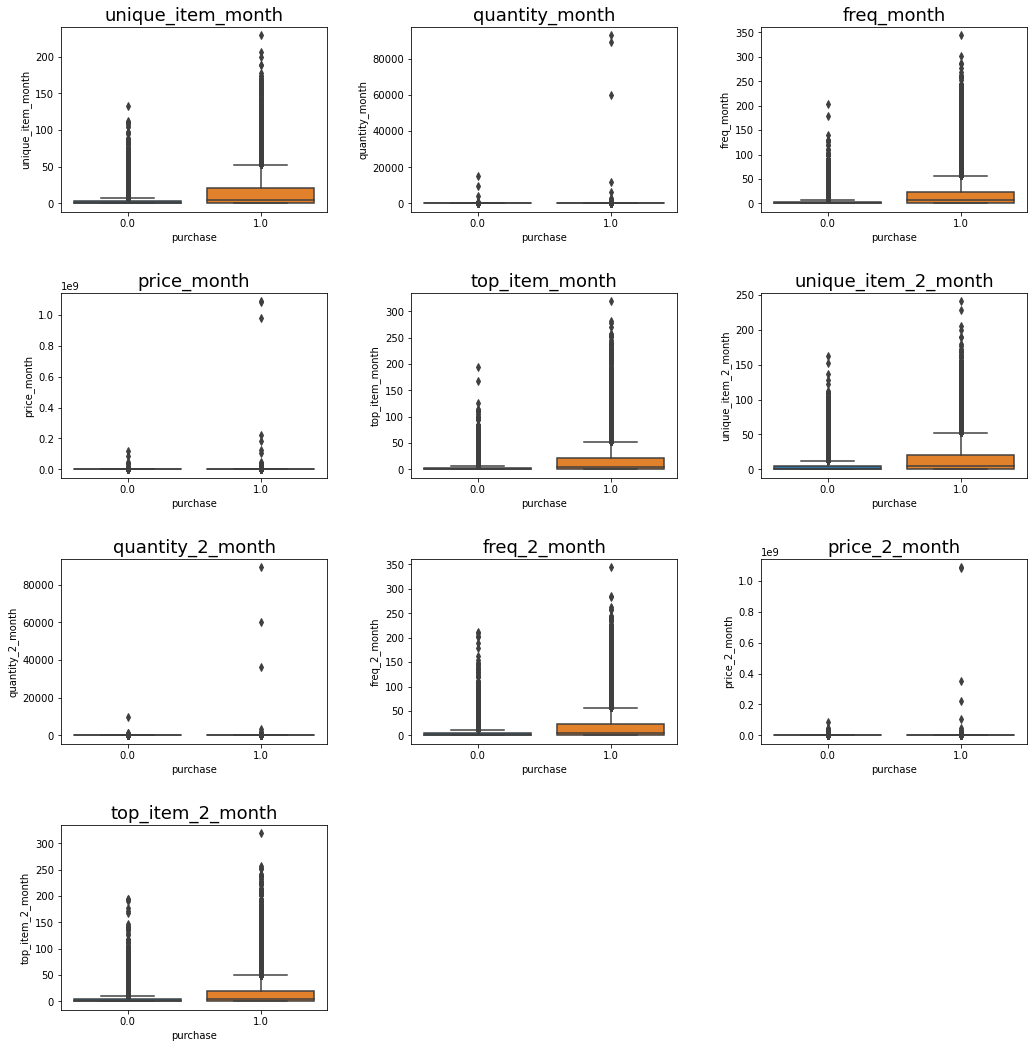

In [20]:
columns=['unique_item_month','quantity_month','freq_month','price_month','top_item_month','unique_item_2_month','quantity_2_month',
         'freq_2_month','price_2_month','top_item_2_month']
fig=plt.figure(figsize=(15,15))
for i,j in enumerate(columns): 
    ax=fig.add_subplot(4,3,i+1)
    fig.tight_layout(pad=3.0)
    sns.boxplot(ax=ax,y = select[j], x = select['purchase']).set_title(str(j),size = 18)

In [22]:
#kiem tra outlier,ngưỡng 1,5iqr, đưa giá trị về đầu mút 1.5iqr
#kiem tra tỷ lệ outlier
df_iqr=select[columns].quantile([0.25,0.75],axis=0).T
df_iqr.columns=['q1','q3']
df_iqr['max_iqr']=df_iqr['q3'] + ((df_iqr['q3'] - df_iqr['q1'])*1.5)
df_iqr['min_iqr']=df_iqr['q1'] - ((df_iqr['q3'] - df_iqr['q1'])*1.5)
df_iqr['attr']=columns
a=[]
for i in columns:
    b=select[(select[i]>df_iqr.loc[i,'max_iqr'])|(select[i]<df_iqr.loc[i,'min_iqr'])][i].count()
    a.append(b)
df_iqr['nbr_outlier']=a
df_iqr['pct_outlier']=df_iqr['nbr_outlier']*100/select[columns].count()
df_iqr

,q1,q3,max_iqr,min_iqr,attr,nbr_outlier,pct_outlier
unique_item_month,0.0,10.000000,2.500000e+01,-15.000000,unique_item_month,6367,10.611667
quantity_month,0.0,14.174000,3.543500e+01,-21.261000,quantity_month,7570,12.616667
freq_month,0.0,10.000000,2.500000e+01,-15.000000,freq_month,6992,11.653333
price_month,0.0,445808.000425,1.114520e+06,-668712.000637,price_month,7479,12.465000
top_item_month,0.0,9.000000,2.250000e+01,-13.500000,top_item_month,7317,12.195000
unique_item_2_month,0.0,11.000000,2.750000e+01,-16.500000,unique_item_2_month,6293,10.488333
quantity_2_month,0.0,16.420000,4.105000e+01,-24.630000,quantity_2_month,7120,11.866667
freq_2_month,0.0,12.000000,3.000000e+01,-18.000000,freq_2_month,6048,10.080000
price_2_month,0.0,545894.249280,1.364736e+06,-818841.373920,price_2_month,7265,12.108333
top_item_2_month,0.0,10.000000,2.500000e+01,-15.000000,top_item_2_month,6630,11.050000


Tỷ lệ outlier 10-12% giá trị các thuộc tính. có thể thấy đối với purchase =1, giá trị outlier có xu hướng tập trung nhiều hơn => các giá trị outlier này là có ý nghĩa, giữ lại ko biến đổi.

### <a id= '2'> 2. Phân tích mô tả

#### <a id='2.1'> 2.1. Đánh giá khả năng tác động từng thuộc tính nên kết quả mục tiêu 

In [23]:
#Kiểm định K-S
ks_test=pd.DataFrame([],columns=['attributes','ks_statistic'])
for x in (columns):
    ks_test_add=pd.DataFrame([])
    a=select[select['purchase']==1][x].values
    b=select[select['purchase']==0][x].values
    ks_test_add['attributes']=[x]
    ks_test_add['ks_statistic']=ks_2samp(a, b).statistic
    ks_test=pd.concat([ks_test,ks_test_add],ignore_index=True)

In [24]:
ks_test

,attributes,ks_statistic
0,unique_item_month,0.304689
1,quantity_month,0.302287
2,freq_month,0.307655
3,price_month,0.296506
4,top_item_month,0.310090
5,unique_item_2_month,0.246945
6,quantity_2_month,0.241305
7,freq_2_month,0.250711
8,price_2_month,0.232187
9,top_item_2_month,0.253331


In [25]:
#Kiểm định t-test
t_test=pd.DataFrame([],columns=['attributes','ttest_pvalue'])
for x in (columns):
    t_test_add=pd.DataFrame([])
    a=select[select['purchase']==1][x].values
    b=select[select['purchase']==0][x].values
    t_test_add['attributes']=[x]
    t_test_add['ttest_pvalue']=stats.ttest_ind(a,b).pvalue
    t_test=pd.concat([t_test,t_test_add],ignore_index=True)

In [26]:
t_test

,attributes,ttest_pvalue
0,unique_item_month,0.000000e+00
1,quantity_month,6.666858e-09
2,freq_month,0.000000e+00
3,price_month,2.255366e-32
4,top_item_month,0.000000e+00
5,unique_item_2_month,0.000000e+00
6,quantity_2_month,5.735479e-10
7,freq_2_month,0.000000e+00
8,price_2_month,5.247349e-35
9,top_item_2_month,0.000000e+00


Với ngưỡng K-s >22%, p-value(t-test) < 0.05, qua kiểm định K-S và t-test, các biến đều có khả năng phân biệt khách hàng mua/không mua

#### <a id= '2.2'> 2.2. Đánh giá tương quan

<AxesSubplot:>

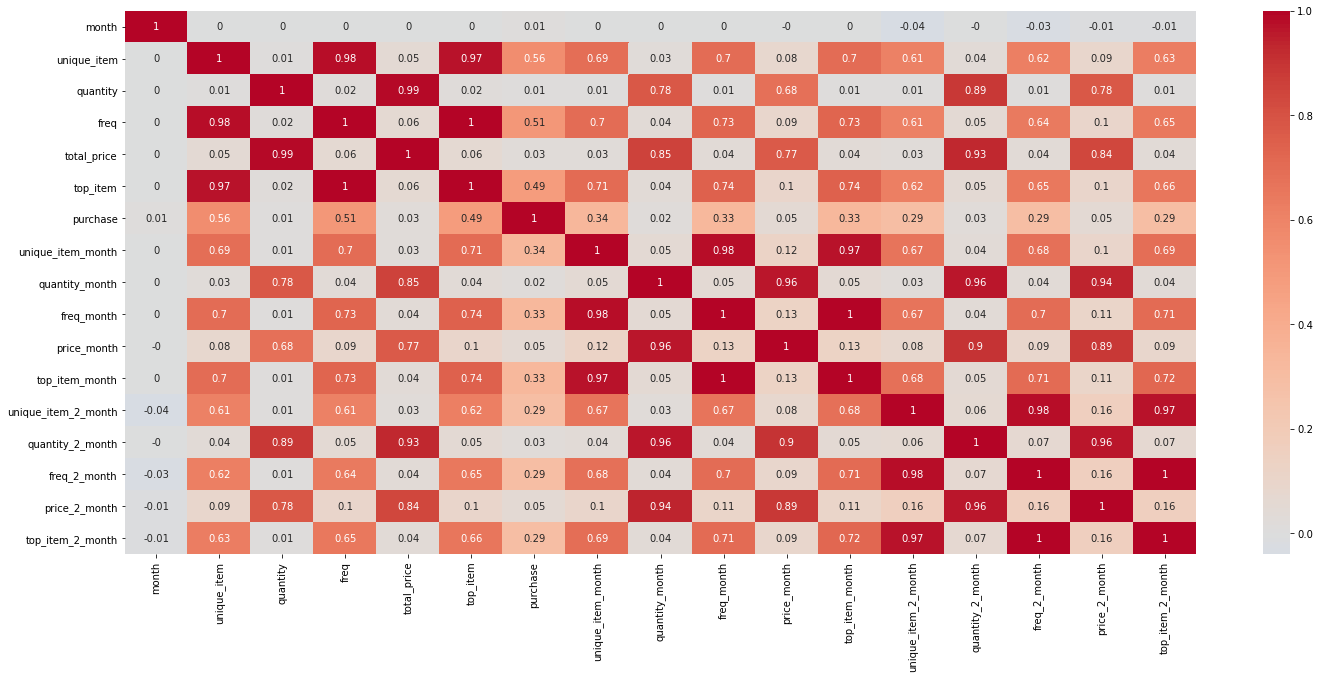

In [27]:
#ma trận tương quan giữa các biến 
corr=select.corr()
fig,ax=plt.subplots(figsize=(24,10))
sns.heatmap(corr.round(2),
            center=0,
            cmap='coolwarm',
            annot=True)

In [28]:
x=select[['unique_item_month','quantity_month','freq_month','price_month','top_item_month','unique_item_2_month','quantity_2_month','freq_2_month','price_2_month','top_item_2_month']]
y=select['purchase']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42, stratify=y)

### <a id= '3'> 3. Mô hình RandomForest

#### <a id= '3.1'> 3.1. Lựa chọn thuộc tính phương pháp tính permutation importance

In [32]:
rf_model= RandomForestClassifier(n_estimators = 100,random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
result = permutation_importance(rf_model, x_train, y_train, n_repeats=5,random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

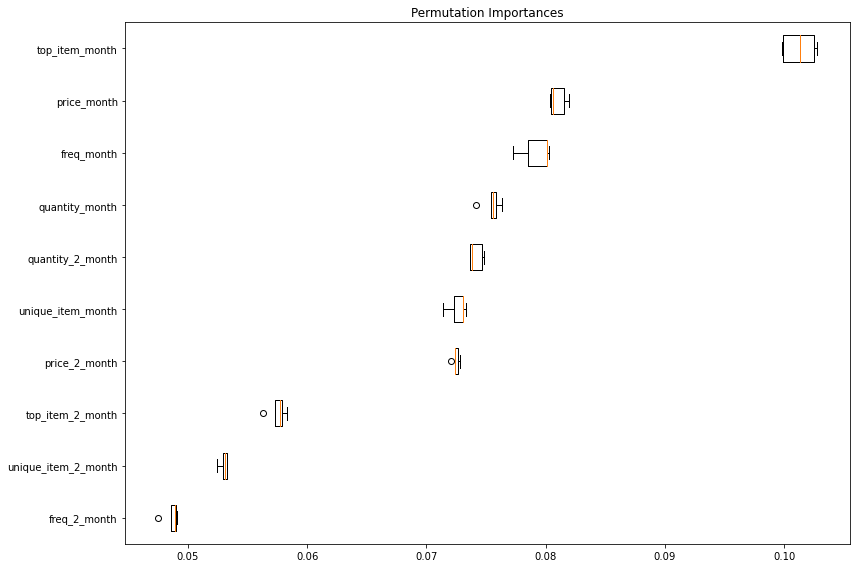

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(result.importances[sorted_idx].T,vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

Lấy top 8 feature importance để xây dựng mô hình: ['unique_item_month','quantity_month','freq_month','price_month','quantity_2_month','price_2_month','top_item_month','top_item_2_month]

#### <a id= '3.2'> 3.2. Xây dựng, tinh chỉnh và đánh giá mô hình

In [35]:
x_train_selected=x_train[['unique_item_month','quantity_month','freq_month','price_month','quantity_2_month','price_2_month','top_item_month','top_item_2_month']]
x_test_selected=x_test[['unique_item_month','quantity_month','freq_month','price_month','quantity_2_month','price_2_month','top_item_month','top_item_2_month']]

In [48]:
model_RF = RandomForestClassifier(n_estimators=100,random_state=42)
grid = {   
    'max_depth': [4, 5, 6],
    'max_features': [4,5,6],
    'min_samples_leaf': [3, 4,5]
    }
rf = GridSearchCV(estimator=model_RF, param_grid=grid, cv=10, scoring = 'roc_auc')
rf.fit(x_train_selected, y_train)

best_depth = rf.best_params_['max_depth']
best_feature = rf.best_params_['max_features']
best_sample_leaf = rf.best_params_['min_samples_leaf']
print(max(rf.cv_results_['mean_test_score']))

0.7280861157626071


In [49]:
#auroc_test
y_pre_selected=rf.predict(x_test_selected)
fpr,tpr,thresholds=metrics.roc_curve(y_test,rf.predict_proba(x_test_selected)[:,1])
rf_auroc_test=metrics.auc(fpr,tpr)
#auroc_train
rf_auroc_train=max(rf.cv_results_['mean_test_score'].round(3))
#confusion matrix, accuracy
rf_confusion_matrix = confusion_matrix(y_test, y_pre_selected)
#accuracy
rf_accuracy=accuracy_score(y_test, y_pre_selected)

In [50]:
rf_auroc_test

0.7329464860112536

In [51]:
rf_auroc_train

0.728

In [52]:
rf_confusion_matrix

array([[8551, 1231],
       [4097, 4121]], dtype=int64)

In [53]:
rf_accuracy

0.704

### <a id= '4'> 4. Mô hình XGBoost

#### <a id= '4.1'> 4.1. Xây dựng mô hình

In [54]:
def modelfit(alg, x_train ,y_train,x_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=70):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(x_test)
    dtest_predprob = alg.predict_proba(x_test)[:,1]
        
    #Print model report:
    print ("Train_Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print ("Train_AUC Score : %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    print ("Test_Accuracy : %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
    print ("Test_AUC Score : %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    print (confusion_matrix(y_test, dtest_predictions))

#### <a id= '4.2'> 4.2. Tuning hyper-parameter

#### Tuning tree-based (n_estimater), cố định ban đầu các para của cây

In [55]:
xgb1 = XGBClassifier(learning_rate =0.05,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27)
modelfit(xgb1, x_train, y_train, x_test, y_test)
xgb1.get_booster().best_iteration

Train_Accuracy : 0.7004
Train_AUC Score : 0.739131
Test_Accuracy : 0.7029
Test_AUC Score : 0.733315
[[8639 1143]
 [4205 4013]]


120

#### Tune max_depth và min_child_weight

In [56]:
param_test1 = {'max_depth':[4,5,6],
               'min_child_weight':[3,4,5]
              }
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=120, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(x_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

[17:57:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 5, 'min_child_weight': 5}, 0.7279079676405099)

#### Tune gamma

In [57]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=120, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,cv=5)
gsearch3.fit(x_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

[17:58:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.0}, 0.7279079676405099)

#### Tune subsample and colsample_bytree

In [58]:
param_test4 = {'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=120, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(x_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

[18:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.7280119584548018)

#### Tuning Regularization Parameters

In [59]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10]
}
gsearch6 =GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=120, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(x_train, y_train)
gsearch6.best_params_, gsearch6.best_score_

[18:03:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 0.01}, 0.7280553829947414)

In [60]:
xgb1 = XGBClassifier( learning_rate =0.05, n_estimators=120, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.6,reg_alpha=0.01,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(xgb1, x_train, y_train, x_test, y_test)

Train_Accuracy : 0.6994
Train_AUC Score : 0.737004
Test_Accuracy : 0.7032
Test_AUC Score : 0.733457
[[8640 1142]
 [4201 4017]]
